# Programación de ganancias basada en una variable auxiliar

Para una planta compuesta por un tanque cónico, con un caudal de salida dado por un orificio de diámetro a, y un caudal de entrada $q_{in}$ se desea simular un control de nivel usando una estrategia PI

Se evalúan los siguientes casos:
- Se toma la ganancia fija y se observa la respuesta dinámica en distintos puntos de trabajo
- Se ajusta la ganancia con la variable auxiliar $A(h)$ 

Simulando...:   0%|                                    | 0/3999 [00:00<?, ?it/s]

Simulando...:   0%|                                    | 0/3999 [00:00<?, ?it/s]

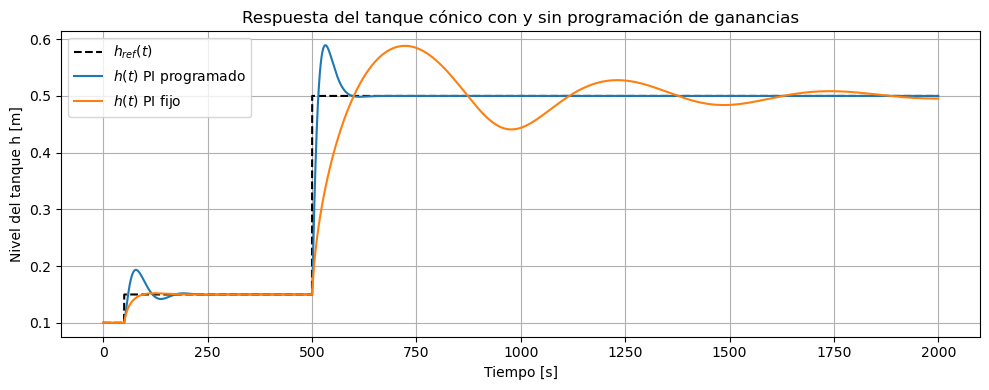

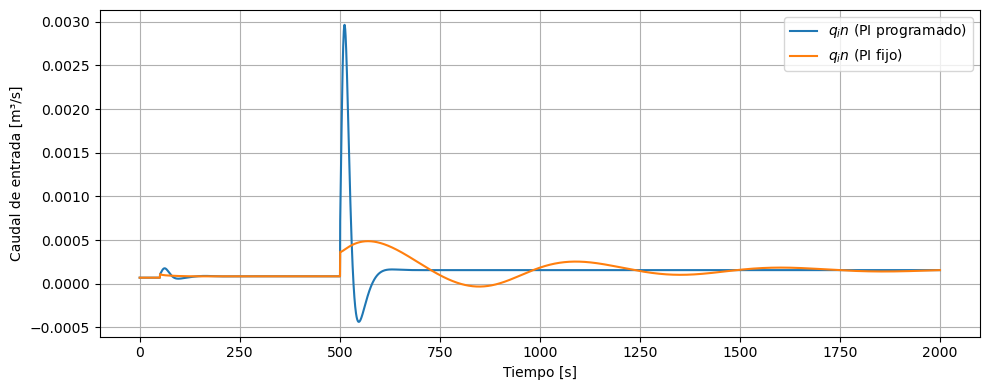

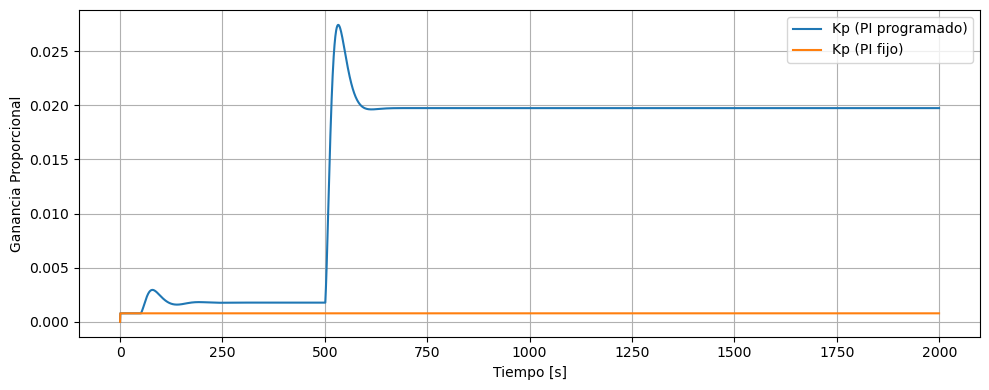

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm  # barra de progreso para Jupyter

# --- Modelo del tanque cónico ---
# Parámetros geométricos y físicos
R = 0.3      # radio superior (m)
H = 0.6      # altura total (m)
a = 5e-5     # área del orificio de salida (m²)
g = 9.81     # gravedad (m/s²)

def A(h):
    """Área transversal del líquido en función del nivel h."""
    Area = np.pi * (R * h / H)**2 if h>0 else 1e-6
    return Area

# --- Dinámica del tanque ---
def tanque(t, h, q_in):
    """Ecuación diferencial dh/dt = (q_in - q_out)/A(h)"""
    q_out = a * np.sqrt(2 * g * h) if h > 0 else 0
    return (q_in - q_out) / A(h)

# --- Simulación ---
def simular(t,h_ref,control_variable=False):
    Ts = t[1]-t[0]
    h = np.zeros_like(t)
    q_in = np.zeros_like(t)
    K_hist = np.zeros_like(t)
    
    # Suponemos que está en estado estacionario en el valor de la referencia
    h[0] = h_ref[0] 
    q_in[0] = -tanque(0,h[0],0)*A(h[0]) # Caudal estático de entrada en el equilibrio

    # parámetros de diseño del control
    xi = 0.8
    omega = 2*np.pi/100

    # Ganancias del control
    Kp0 = 2*xi*omega * A(h[0]) 
    Ti = 2*xi/omega

    e_int = q_in[0]*(Ti/Kp0)

    #print(f'Ganancias estáticas del control. Kp={Kp0}   Ti={Ti}')
    
    for k in tqdm(range(1, len(t)), desc="Simulando...", ncols=80):
        e = h_ref[k-1] - h[k-1]
        if control_variable:
            Kp = Kp0*A(h[k-1])/A(h[0]) 
        else:
            Kp = Kp0
        
        K_hist[k] = Kp
        # Calculo la acción del controlador
        e_int += e * Ts
        q = Kp * e + Kp/Ti * e_int

        # saturar caudal de entrada
        #q = np.clip(q, 0, 5e-4)
        q_in[k] = q

        # integrar nivel
        sol = solve_ivp(lambda t_, h_: tanque(t_, h_, q), 
                        [0, Ts], [h[k-1]], method='RK45', max_step=Ts)
        h[k] = sol.y[0, -1]

    return t, h, q_in, K_hist


Ts = 0.5       # paso de muestreo (s)
tf = 2000       # tiempo final (s)
t = np.arange(0, tf, Ts)

h_ref = np.ones_like(t) * 0.1
h_ref[t > 50] = 0.15  # salto en la referencia
h_ref[t > 500] = 0.5  # salto en la referencia


# --- Ejecutar simulaciones ---
t, h_fijo, q_fijo, Kp0 = simular(t,h_ref,control_variable=False)
_, h_prog, q_prog, Kp = simular(t,h_ref,control_variable=True)

# --- Graficar ---
plt.figure(figsize=(10,4))
plt.plot(t, h_ref, 'k--', label='$h_{ref}(t)$')
plt.plot(t, h_prog, label='$h(t)$ PI programado')
plt.plot(t, h_fijo, label='$h(t)$ PI fijo')
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel del tanque h [m]')
plt.title('Respuesta del tanque cónico con y sin programación de ganancias')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Segundo gráfico: caudal de control ---
plt.figure(figsize=(10,4))
plt.plot(t, q_prog, label='$q_in$ (PI programado)')
plt.plot(t, q_fijo, label='$q_in$ (PI fijo)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Caudal de entrada [m³/s]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Tercer gráfico: evolución de la ganancia Kp ---
plt.figure(figsize=(10,4))
plt.plot(t, Kp, label='Kp (PI programado)')
plt.plot(t, Kp0, label='Kp (PI fijo)')
plt.ylabel('Ganancia Proporcional')
plt.xlabel('Tiempo [s]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
